# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
print(os.getcwd())

/home/workspace/aipnd-project


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
#Directory paths

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(35),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])]) 

test_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)

In [4]:
#Function provided by Udacity to visualize the images

import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

torch.Size([64, 3, 224, 224])


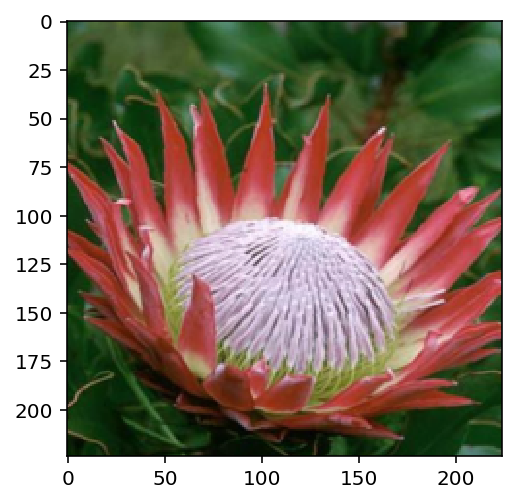

In [5]:
#Check if the data is loaded
image, label = next(iter(trainloader))
imshow(image[0,:])
print(image.shape)


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json


with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
  
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [7]:
# TODO: Build and train your network

#Pre-trainned network load, (VGG-19)

model = models.vgg19(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:05<00:00, 98723657.28it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [8]:
#New Classifier class definition, based on the model used in classroom examples

class Classifier(nn.Module):
    def __init__(self,input_size,hidden_layers,output_size,drop_p=0.2):
        
        '''Creates a feedforward NN with different input size, hidden layers and output size
        
           Parameters:
           
           input_size    : integer, size of the input layer
           hidden_layers : integer list, the sizes of the hidden layers
           output_layers : integer, size of the output layer
           drop_p        : float, the dropout probability for the network to reduce overfit
           
        '''
        super().__init__()
        
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        #Dropout definition
        self.dropout = nn.Dropout(p=drop_p)
    
    
    
    def forward(self, x):
        
        ''' forward method with the different functions per layer 
        
        input : features tensor
        output: logits
        
        Relu function is used for the hidden layers
        LogSoftmax for output layer
        
        ''' 
        
        # flat input tensor if neccesary
        
        x = x.view(x.shape[0], -1)
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)



In [9]:
#Trainning and  validation  function based on the classroom examples

def train_validation(model, trainloader, val_loader, criterion, optimizer, epochs, device):
    ''' Function to train and validate the model
     
        Params:
        
        model        : model to train
        trainloader  : train image batch
        val_loader   : validate image batch
        criterion    : criterion function
        optimizer    : optimizer definition
        epochs       : epoch number
        device       : CPU or GPU when available 
        
        Returns:
        
        train_losses : list with the train losses
        val_losses   : list with the validation losses
        accuracy_list: list with the accuracy results '''
    
    import time
    
    running_loss = 0
    train_losses = []
    val_losses = []
    accuracy_list = []   #To graph and compare if trainning vs valuation is not overfitted

    print('Start trainning the model...')

    for epoch in range(epochs):
        batch = 0
        running_loss = 0
        for inputs, labels in trainloader:
            batch += 1
        
        # Move input and label tensors to the default device
               
            inputs, labels = inputs.to(device), labels.to(device)
        
            start = time.time()
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            end = time.time()
            diff = end - start
            
            if batch % 10 == 0:    
                print('Trainning Epoch: {}  Trainning Batch: {}  time: {} loss {}'.format(epoch,batch,diff,loss.item()))
        else:
            val_loss = 0
            accuracy = 0
            model.eval()   
            batch = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    batch += 1
                
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    val_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    print('Epoch: {}  Evaluation Batch: {} loss {} '.format(epoch,batch,batch_loss.item()))   
            
            train_losses.append(running_loss/len(trainloader))
            val_losses.append(val_loss/len(val_loader))
            accuracy_list.append(accuracy/len(val_loader))
            
            
            print('Epoch: {} Train Loss: {:.3f} Valuation Loss: {:.3f} Accuracy: {:.3f}'.format(epoch+1,train_losses[-1],
                                                                                   val_losses[-1],accuracy_list[-1]*100))
            model.train()

    return train_losses, val_losses, accuracy_list
    

In [10]:
#Test function based on classroom examples

def test(model, testloader):
    '''Function to test the model
       Params:
       
       model      : trainned model
       tesloader  : test images batch
       
       Return:
       
       accuracy_list : a list with the accuracy for each tested batch'''

    test_loss = 0
    accuracy = 0
    accuracy_list = []
    model.eval()
    batch = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            batch += 1
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
                    
            test_loss += batch_loss.item()
                    
                # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            acc = torch.mean(equals.type(torch.FloatTensor)).item()
            accuracy += acc
            print(' Batch: {} loss {} '.format(batch,batch_loss.item()))   
            accuracy_list.append(acc)
        
        print('Test loss: {:.3f} General Test Accuracy: {:.3f}'.format(test_loss/len(testloader),accuracy/len(testloader)))  

    return accuracy_list
        

    

In [11]:
#Classifier creation

input_size = 25088           #Based on pretrained model VGG-19 in_features value
hidden_layers = [4096,512]   #Two hidden layers, after different hidden layers validation tests, this gives the best accuracy
output_size = 102            # According with the 102 flower classes
drop_p  = 0.2          

classifier = Classifier(input_size,hidden_layers,output_size,drop_p)



In [12]:
#Freeze params for the pretrainned model and avoid back propagation

for param in model.parameters():
    param.requires_grad = False

#Assign new Classifier to replace the one from pretrainned model

model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [13]:
#Set device  CUDA when is enabled if Not CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
#Define Criterion function and optimizer

criterion = nn.NLLLoss()  #Loss function Negative Log

#Adam back propagation optimizer with learning rate = 0.001
lr = 0.0001
optimizer = optim.Adam(model.classifier.parameters(), lr)

#Move to the device available
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [46]:
#Train and evaluate the model

epochs = 10

t_loss, v_loss, accuracy = train_validation(model, trainloader, val_loader, criterion, optimizer, epochs, device)


Start trainning the model...
Trainning Epoch: 0  Trainning Batch: 10  time: 0.9757740497589111 loss 4.431262493133545
Trainning Epoch: 0  Trainning Batch: 20  time: 0.997577428817749 loss 4.134437084197998
Trainning Epoch: 0  Trainning Batch: 30  time: 0.9788069725036621 loss 3.54351544380188
Trainning Epoch: 0  Trainning Batch: 40  time: 1.023655652999878 loss 3.345787286758423
Trainning Epoch: 0  Trainning Batch: 50  time: 0.9647972583770752 loss 2.8007102012634277
Trainning Epoch: 0  Trainning Batch: 60  time: 0.9975743293762207 loss 2.771641492843628
Trainning Epoch: 0  Trainning Batch: 70  time: 0.9740433692932129 loss 2.5575544834136963
Trainning Epoch: 0  Trainning Batch: 80  time: 1.0288527011871338 loss 2.143282175064087
Trainning Epoch: 0  Trainning Batch: 90  time: 0.9833588600158691 loss 2.0231640338897705
Trainning Epoch: 0  Trainning Batch: 100  time: 1.00905442237854 loss 1.9836806058883667
Epoch: 0  Evaluation Batch: 1 loss 2.1198253631591797 
Epoch: 0  Evaluation Batch

Text(0.5,0,'Epochs')

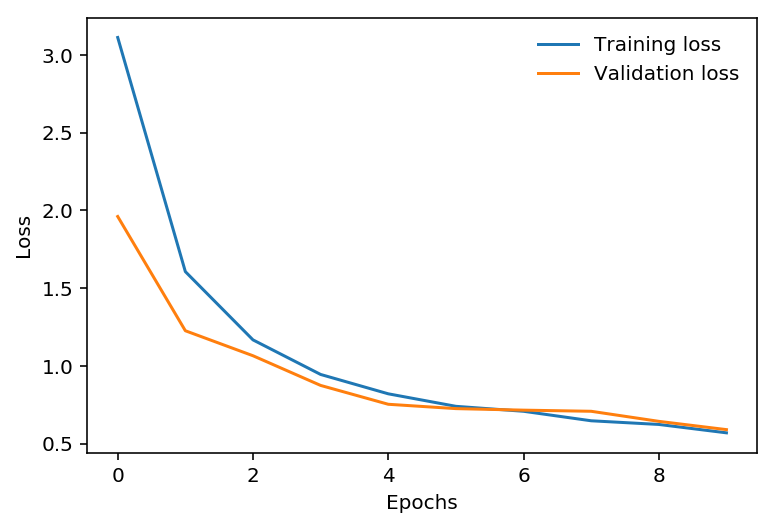

In [49]:
#Check the test vs validatios loss for overfit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(t_loss, label='Training loss')
plt.plot(v_loss, label='Validation loss')
plt.legend(frameon=False)
plt.ylabel('Loss')
plt.xlabel('Epochs')


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [50]:
# TODO: Do validation on the test set

accuracy_list = test(model, testloader)
  

 Batch: 1 loss 0.7792919278144836 
 Batch: 2 loss 0.920369565486908 
 Batch: 3 loss 0.7226219773292542 
 Batch: 4 loss 0.6874274015426636 
 Batch: 5 loss 0.768921971321106 
 Batch: 6 loss 0.8232985138893127 
 Batch: 7 loss 0.5619523525238037 
 Batch: 8 loss 0.5238624215126038 
 Batch: 9 loss 0.5341854095458984 
 Batch: 10 loss 0.7437297105789185 
 Batch: 11 loss 0.6340345740318298 
 Batch: 12 loss 0.8535609245300293 
 Batch: 13 loss 0.7377527952194214 
Test loss: 0.715 General Test Accuracy: 0.787


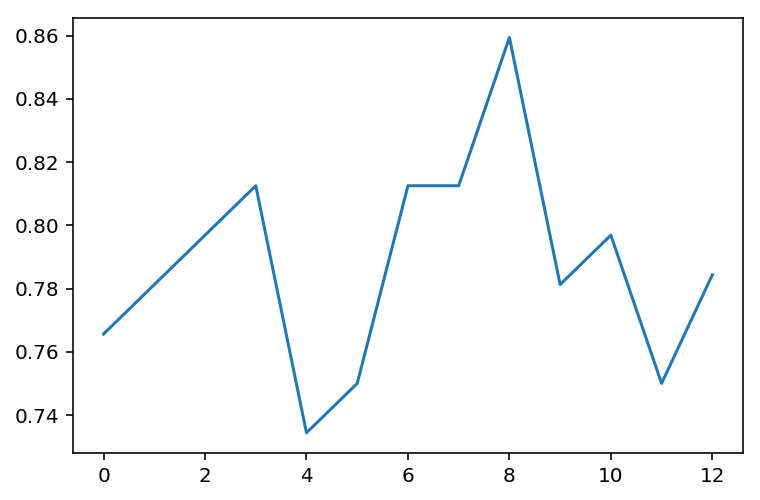

In [51]:
plt.plot(accuracy_list)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [22]:
# TODO: Save the checkpoint 
def save_checkpoint(model,optimizer,input_size,output_size,drop_p,epochs,lr,train_data,filepath):
    
    ''' Fucntion to saved a checkpoint for the trainned model
        Parameters :
        model      : the trainned model
        optimizer  : the optimizer used
        input_size : classifier input size
        output_size: classifier output size
        drop:p.    : dropout probability
        epochs.    : epochs used
        train_data : train_data used
        filepath.  : checkpoint filepath '''

    #Move the model to CPU mode to allow predictions without GPU resources
    model.to('cpu')
    
    model.class_to_idx = train_data.class_to_idx 
    checkpoint = {'input_size': input_size,
              'output_size': output_size,
              'hidden_layers': [each.out_features for each in model.classifier.hidden_layers],
              'drop_p': drop_p,    
              'classes_to_idx' : model.class_to_idx, 
              'epochs': epochs,
              'lr': lr,
              'optimizer_state_dict':optimizer.state_dict(),
              'state_dict': model.state_dict()}
    
    print('Start saving the model... as: {}'.format(filepath))
    torch.save(checkpoint, filepath)
    print('Model Saved!!!')
    
    

filepath = 'checkpoint.pth'
save_checkpoint(model, optimizer, input_size, output_size, drop_p, epochs, lr, train_data, filepath)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_model(filepath,msg=True):
    
    ''' Function to load the model in a CPU or GPU if available
        
        Parameters:
        
        filepath  : String, filepath for the checkpoint
        msg       : Boolean flag to see feedback messages about the restoring process
        
        Returns:
        model     : the pretrained model with the classifier saved
        optimizer : the optimizer and their state dict '''
     
    #Check device available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    #Get the checkpoint specified
    if msg:
        print('Start loading the saved model...')
    
    if str(device) == "cpu":
        checkpoint = torch.load(filepath,map_location="cpu") #Use CPU
    else:
        checkpoint = torch.load(filepath,map_location="cuda:0") #Use GPU
            
    # Set the pretrainned model used
    model = models.vgg19(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    #Rebuild the classifier
    classifier = Classifier(input_size = checkpoint['input_size'],
                         output_size = checkpoint['output_size'],
                         hidden_layers = checkpoint['hidden_layers'],
                         drop_p = checkpoint['drop_p'])
    
    model.classifier = classifier
 
    #Load model and optimizer state dict
    model.class_to_idx = checkpoint['classes_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer = optim.Adam(model.classifier.parameters(), checkpoint['lr'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if msg:
        print('Model loaded!!!')
    
    return model,optimizer



#load model testing
filepath = 'checkpoint.pth'
model,optimizer = load_model(filepath)


Start loading the saved model...
Model loaded!!!


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [16]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    img = Image.open(image)   #Open image with PIL 
    
    #Apply Transformations using transforms
    adjust = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    imgt = adjust(img)
    
    return imgt

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [20]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

flowers/test/81/image_00869.jpg
flowers/test/10/image_07104.jpg
flowers/test/42/image_05696.jpg
flowers/test/91/image_04860.jpg
flowers/test/67/image_07079.jpg
flowers/test/89/image_00724.jpg
flowers/test/96/image_07596.jpg
flowers/test/57/image_07267.jpg


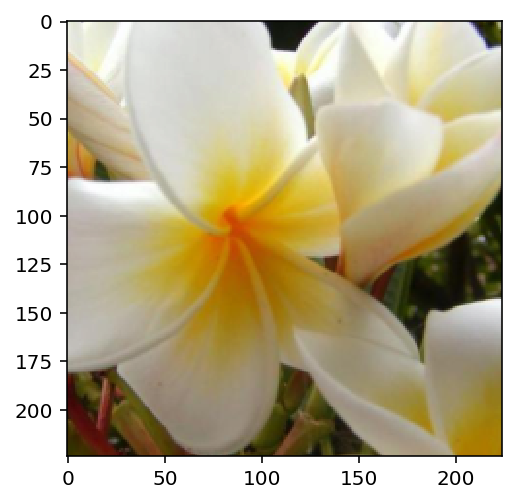

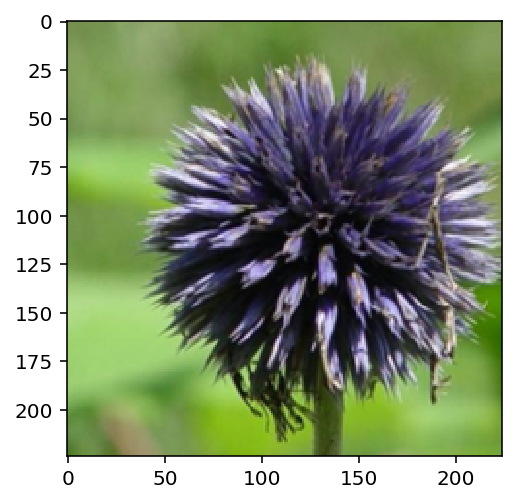

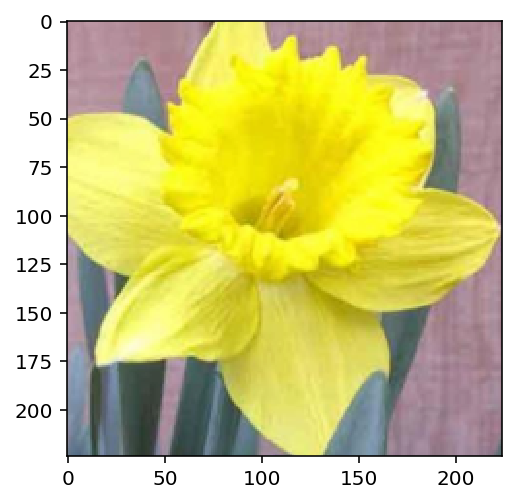

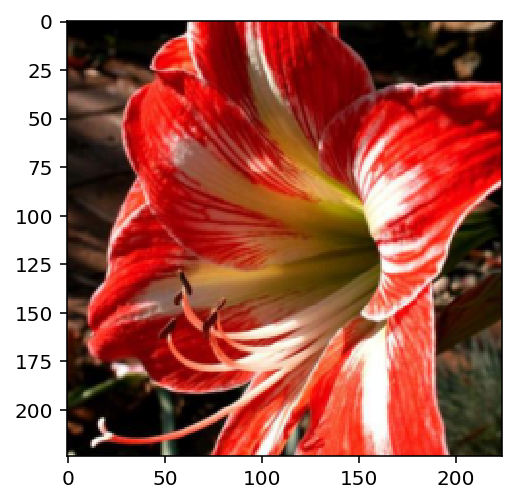

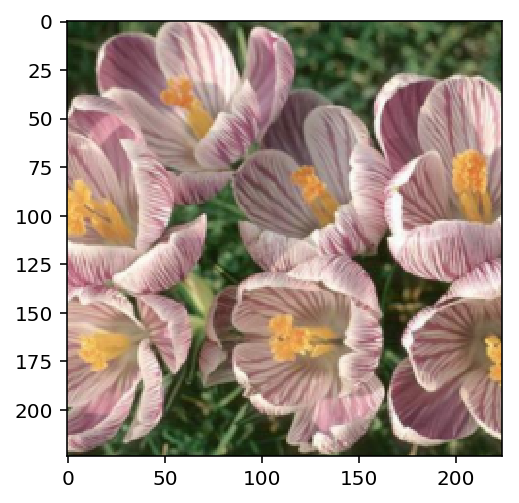

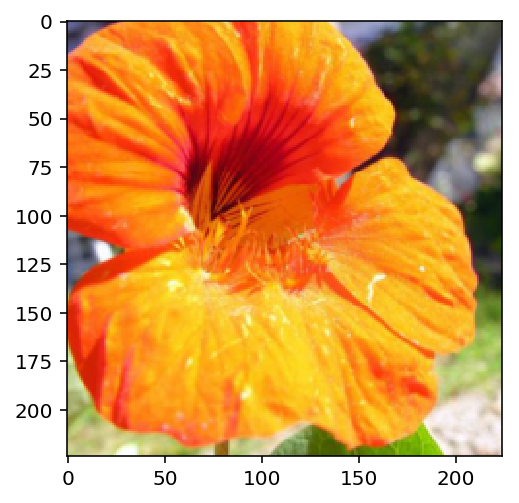

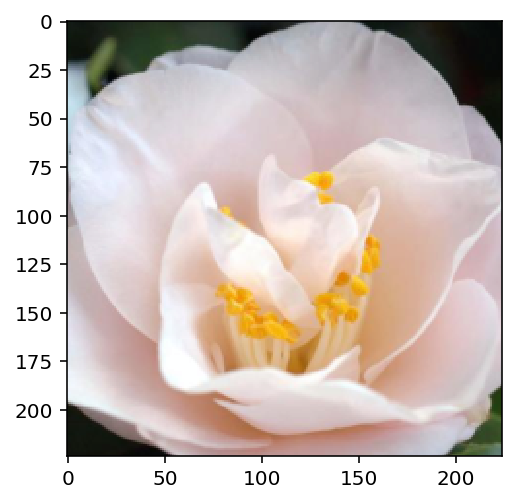

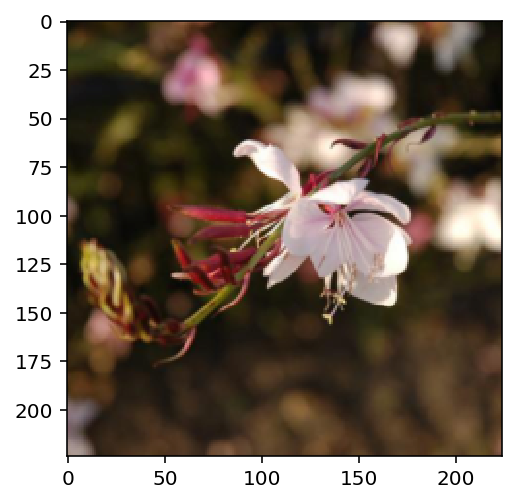

In [21]:
#Loader testing

for i in range(8):
    class_dir = np.random.randint(1,102) 
    path = '{}/{}/'.format(test_dir,class_dir)
    image_path = path + os.listdir(path)[0]
    print(image_path)
    imshow(process_image(image_path))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [22]:
def predict(image_path, checkpoint, topk=5,msg=True):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
        Params:
        
        image_path     : dir where is the image
        model          : trainned model
        topk           : number of top classes to return
        
        Returns:
        top_p          : highest topk probabilies
        top_class_idx  : top classes index
        checkpoint.    : Trainned model checkpoint
        msg            : Bool to display feedback messages
        
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    model,optimizer = load_model(checkpoint,msg)   #Load the saved model
    
    top_class_idx = []
    image = process_image(image_path)
    image = image.unsqueeze(0)
    idx_to_class = {value : key for (key, value) in model.class_to_idx.items()} #ReMap idx to classes
    model.eval()
    
    #Check device available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #Move to the device 
    model.to(device)
    image = image.to(device)
    
    with torch.no_grad():
        logps = model.forward(image)
                           
        # Top k classifications
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(topk, dim=1)
        
    for i in top_class[0]:
        idx = idx_to_class[i.item()]
        top_class_idx.append(idx)
    
    return top_p, top_class_idx
      


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [23]:
# TODO: Display an image along with the top 5 classes

def sanity_check(img_path, ps, cat_to_names, idx_names):
    ''' Function for checking the model sanity, based on classroom examples.
        
        Params:
        
        img_pa       : image path
        ps           : probability classes Tensor
        cat_to_names : dictionary with the class to flower names map
        idx_names    : list with the top 5 classes index
      
        
        
        Returns : None
    '''
    
    img = Image.open(img_path)
    class_names = []
    
    # Convert index to flower names
    for n in idx_names:
        class_names.append(cat_to_names[n])
    
    ps = ps.cpu()    
    ps = ps.data.numpy().squeeze()         #Convert torch Tensor to numpy array
   
    flower = class_names[np.argmax(ps)]    #Get the flower  name with max probability 
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), nrows=2)
    ax1.set_title(flower)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(class_names, ps)
    ax2.set_title('Classes Probability')
    ax2.set_xlim(0, 1.1)
    ax2.invert_yaxis()

    return None  


Start loading the saved model...
Model loaded!!!


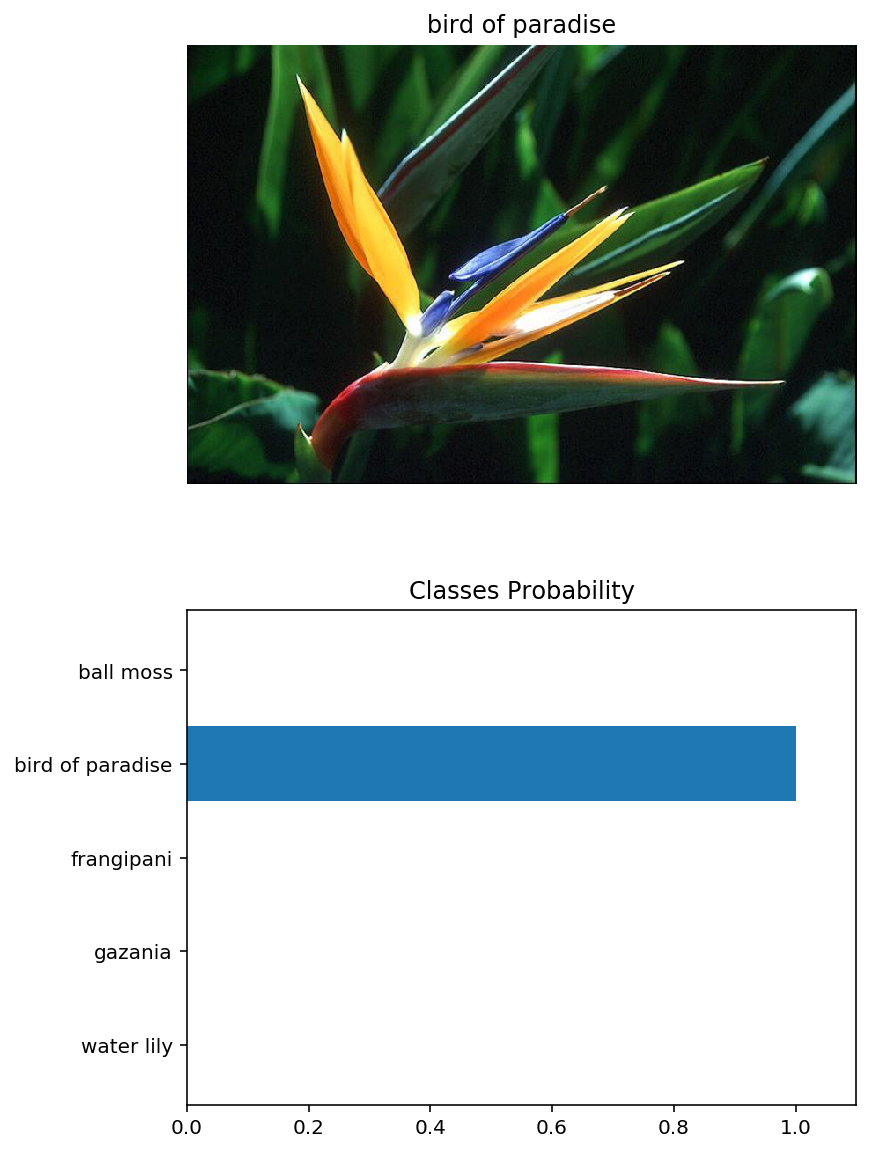

In [24]:
#Sanity check with one test flowerc

image_path = 'flowers/test/8/image_03319.jpg'
filepath = 'checkpoint.pth'
prob,idx_names = predict(image_path, filepath, topk=5)
sanity_check(image_path, prob, cat_to_name, idx_names)


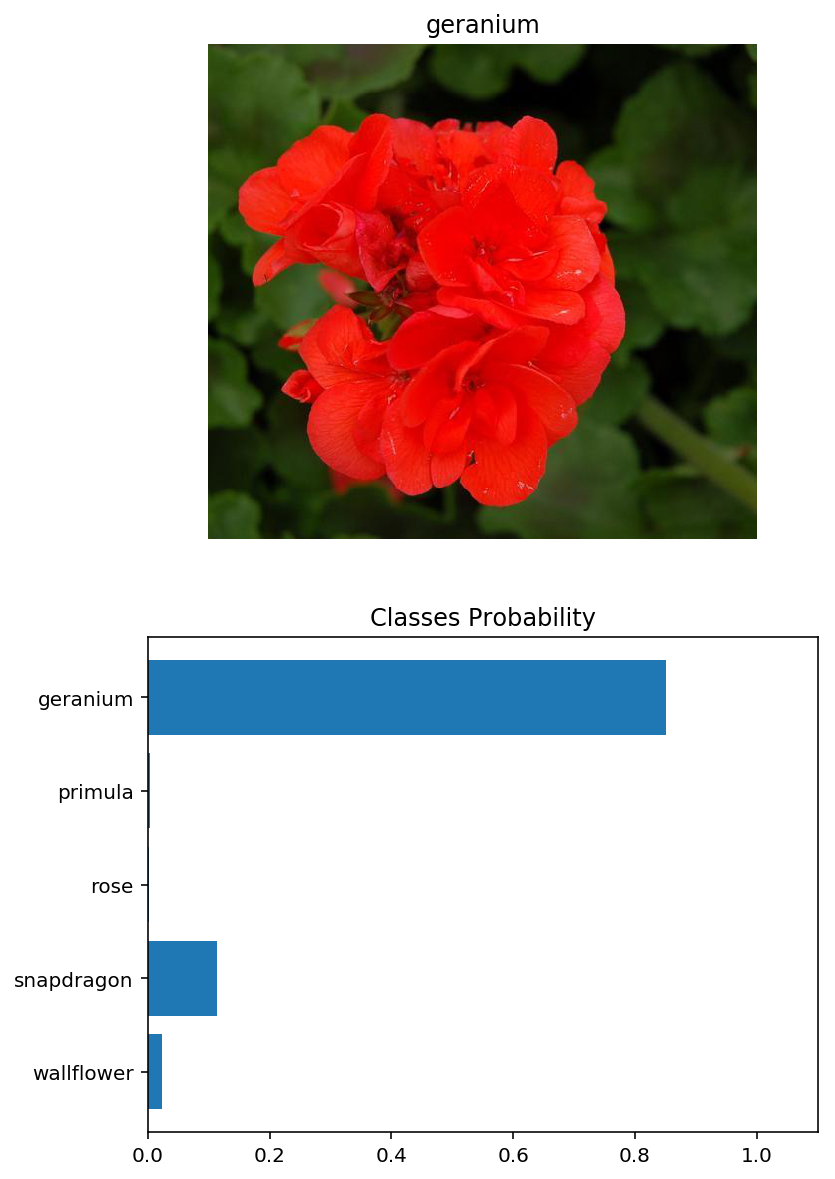

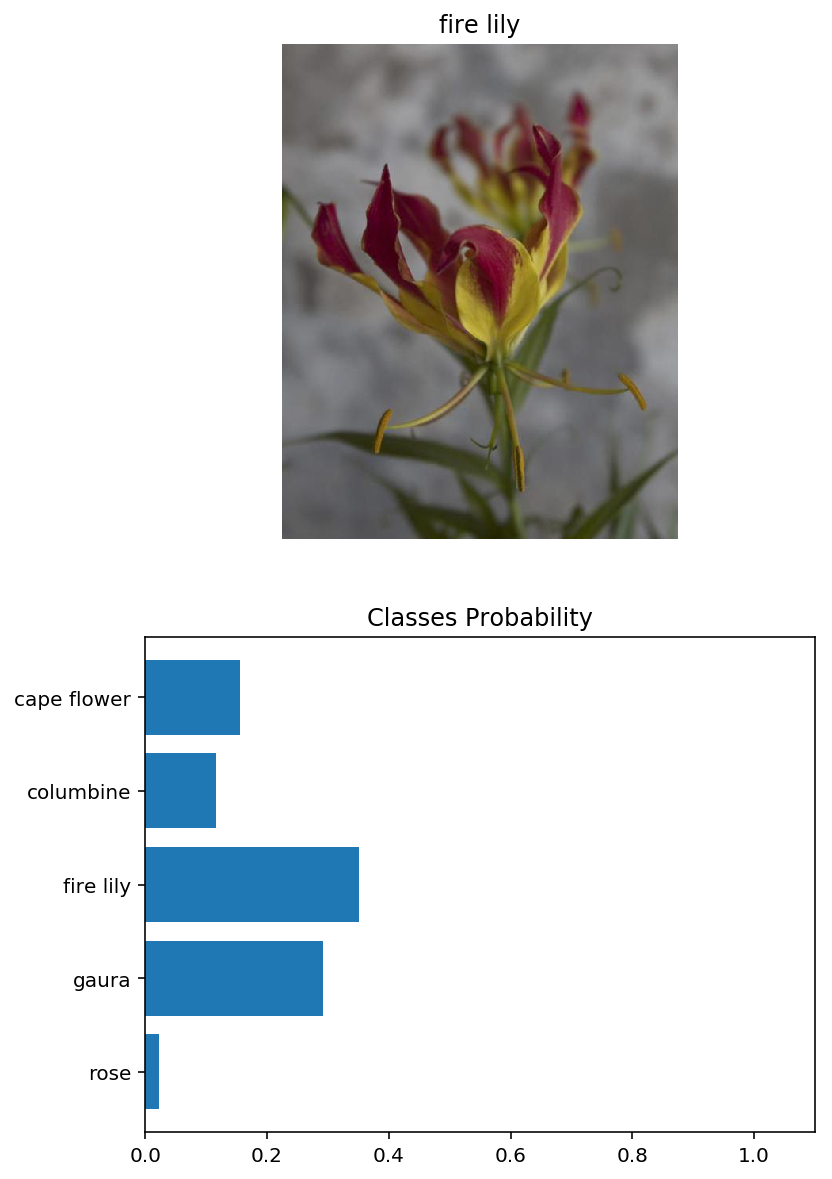

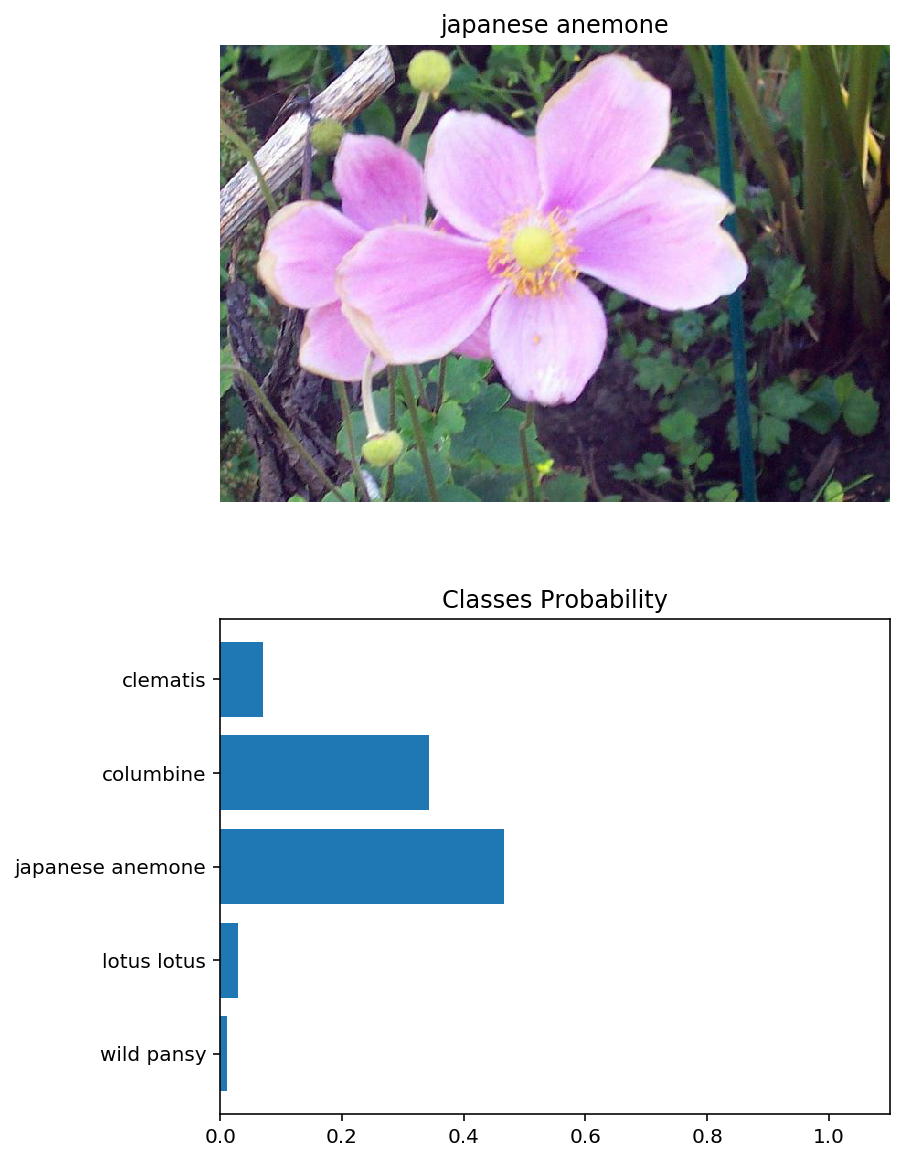

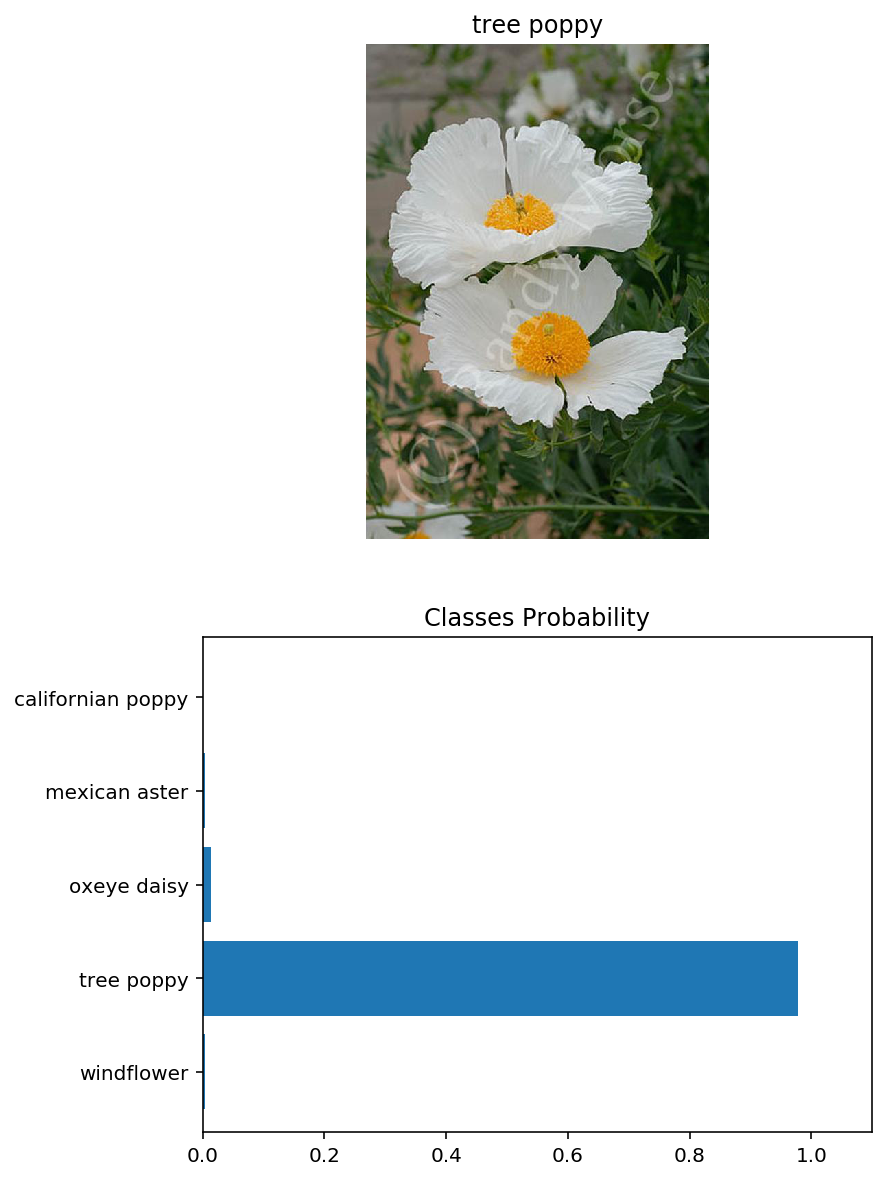

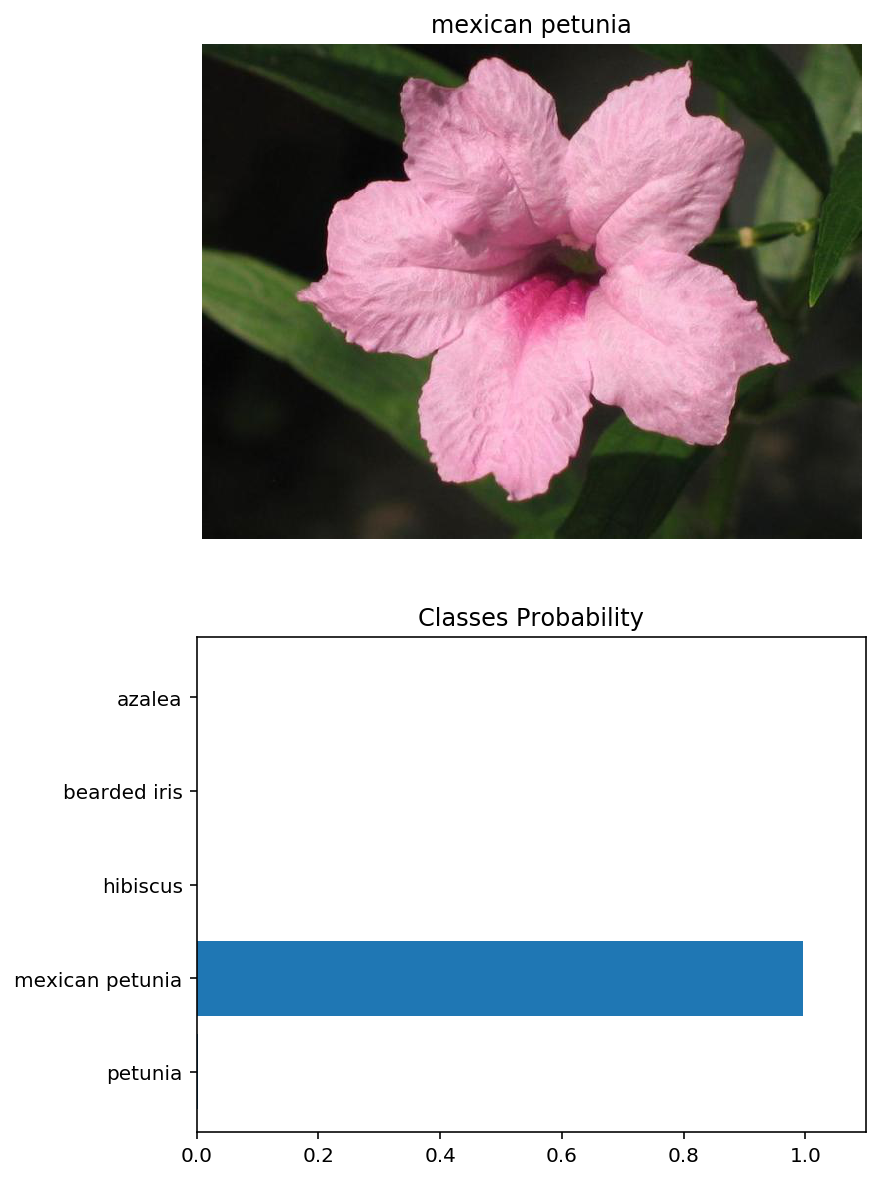

In [23]:
#Sanity chech with random classes pick from the 102 availables
flowers = 5
for i in range(flowers):
    class_dir = np.random.randint(1,102) 
    path = '{}/{}/'.format(test_dir,class_dir)
    image_path = path + os.listdir(path)[0]
    prob,idx_names = predict(image_path, filepath, topk=5,msg=False)
    sanity_check(image_path, prob, cat_to_name, idx_names)